# MedRead

## Problem in a sentence
The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

## Solution in a sentence
Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature and dive deeper when necessary.

**Where our data is coming from**: PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts

**Where our model is coming from**: Neural networks for joint sentence classification in medical paper abstracts.

## Confirm access to a GPU


In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9b497b4c-6c01-1342-cd0f-295bbdaed8f7)


## Get data

Before we can start building a model, we've got to download the PubMed 200k RCT dataset.
We can copy them to our local directory using git clone https://github.com/Franck-Dernoncourt/pubmed-rct.



In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 22.95 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


Looking at the README file from the GitHub page, we get the following information:

* PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
* PubMed_200k_RCT is the same as PubMed_200k_RCT_numbers_replaced_with_at_sign, except that in the latter all numbers had been replaced by @. (same for PubMed_20k_RCT vs. PubMed_20k_RCT_numbers_replaced_with_at_sign).
* Since Github file size limit is 100 MiB, we had to compress PubMed_200k_RCT\train.7z and PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip. To uncompress train.7z, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.


To begin with, the dataset we're going to be focused on is PubMed_20k_RCT_numbers_replaced_with_at_sign.

Why this one?

Rather than working with the whole 200k dataset, we'll keep our experiments quick by starting with a smaller subset. We could've chosen the dataset with numbers instead of having them replaced with @ but we didn't.

In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Because our data is in the form of text files, let's write some code to read each of the lines in a target file.

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Let's write a function to perform the following steps:

* Take a target file of abstract samples.
* Read the lines in the target file.
* For each line in the target file:
* * If the line begins with ### mark
** it as an abstract ID and the beginning of a new abstract.
* * * Keep count of the number of lines in a sample.
* * If the line begins with \n mark it as the end of an abstract sample.
* * *  Keep count of the total lines in a sample.
* * Record the text before the \t as the label of the line.
* * Record the text after the \t as the text of the line.
* Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
* * * "line_number" - the position of the line in the abstract (e.g. 3).
* * * "target" - the role of the line in the abstract (e.g. OBJECTIVE).
* * * "text" - the text of the line in the abstract.
* * * "total_lines" - the total lines in an abstract sample (e.g. 14).
* Abstract ID's and newlines should be omitted from the returned preprocessed data.


Example returned preprocessed sample (a single line from an abstract):

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 725 ms, sys: 126 ms, total: 851 ms
Wall time: 1.6 s


(180040, 30212, 30135)

In [11]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


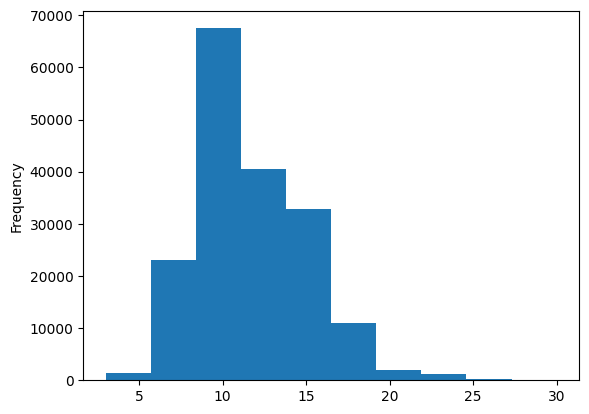

In [14]:
train_df.total_lines.plot.hist();

## Get lists of sentences


In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numerical labels(ML model require number labels)

In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
# check the labels
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [18]:
# Extract labels("target columns") and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# check the labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class name and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline
Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by Scikit-Learn's machine learning map.

To build it, we'll create a Scikit-Learn Pipeline which uses the `TfidfVectorizer` class to convert our abstract sentences to numbers using the `TF-IDF (term frequency-inverse document frequecy)` algorithm and then learns to classify our sentences using the MultinomialNB aglorithm.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0  = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

To evaluate our baseline's predictions, we'll import the calculate_results() function we created in the previous notebook and added it to our helper_functions.py script to compare them to the ground truth labels.

More specificially the calculate_results() function will help us obtain the following:

* Accuracy
* Precision
* Recall
* F1-score

In [23]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-20 16:52:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-20 16:52:59 (86.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

But before we start building deeper models, we've got to create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

To start creating our vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy).

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

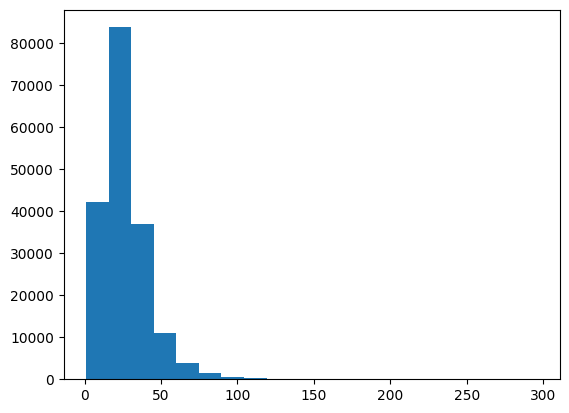

In [28]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

We can use NumPy's percentile to find the value which covers 95% of the sentence lengths.

In [29]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

In [30]:
# Maximum sentence length in the training set
max(sent_lens)

296

### Create a Text Vectorizer layer

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.

In [31]:
# How many words are in our vocabulary?
max_tokens = 68000

And since a sentence length of 55 covers 95% of the training sentences, we'll use that as our output_sequence_length parameter.

In [32]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [33]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text : {text_vectorizer([target_sentence])}")

Text:
 to investigate the treatment of benign positional paroxysmal vertigo of posterior semi-circular canal by epley maneuver combined with semont maneuver .

Length of text: 21

Vectorized text : [[    6   331     2    19     4  2448  8610  3558  7954     4  1262 24662
   3861    22 12684  4318   286     7 21797  4318     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# How many words in our training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab : {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab : {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab : {rct_20k_text_vocab[-5:]}")

Number of words in vocab : 64841
Most common words in the vocab : ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
 # Get the config of our text vectorizer
 text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [37]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = "token_embedding")

In [38]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 to investigate the treatment of benign positional paroxysmal vertigo of posterior semi-circular canal by epley maneuver combined with semont maneuver .

Sentence after vectorization (before embedding):
[[    6   331     2    19     4  2448  8610  3558  7954     4  1262 24662
   3861    22 12684  4318   286     7 21797  4318     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.03685707  0.02834697  0.03632582 ... -0.02612648 -0.04283682
    0.04648728]
  [-0.02051724 -0.02893815 -0.02047063 ... -0.0132603   0.02508489
   -0.03493685]
  [-0.02216013  0.01594969  0.01985953 ... -0.01540239 -0.0258696
   -0.01216064]
  ...
  [-0.00796697 -0.01392579 -0.03913075 ... -0.04059658  0.04954424
   -0.00175923]
  [-0.00796697 -0.01392579 -0.03913075 ... -0.04059658  0.04

## Create datasets (as fast as possible)

Namely, the `tf.data` API provides methods which enable faster data loading.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset we can use the methods `batch()` and `prefetch()`, the parameter `tf.data.AUTOTUNE` will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [39]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1 : Conv1D with token embeddings

In [41]:
# Create 1D conv model to process sentences
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # Vectorize text inputs
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size = 5,padding = "same",activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation = "softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = "adam",
                metrics = ["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [42]:

model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5204 - loss: 1.1682 - val_accuracy: 0.7381 - val_loss: 0.6973
Epoch 2/3
 20/562 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7396 - loss: 0.7400

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7498 - loss: 0.6839 - val_accuracy: 0.7722 - val_loss: 0.6399
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7706 - loss: 0.6225 - val_accuracy: 0.7886 - val_loss: 0.5973


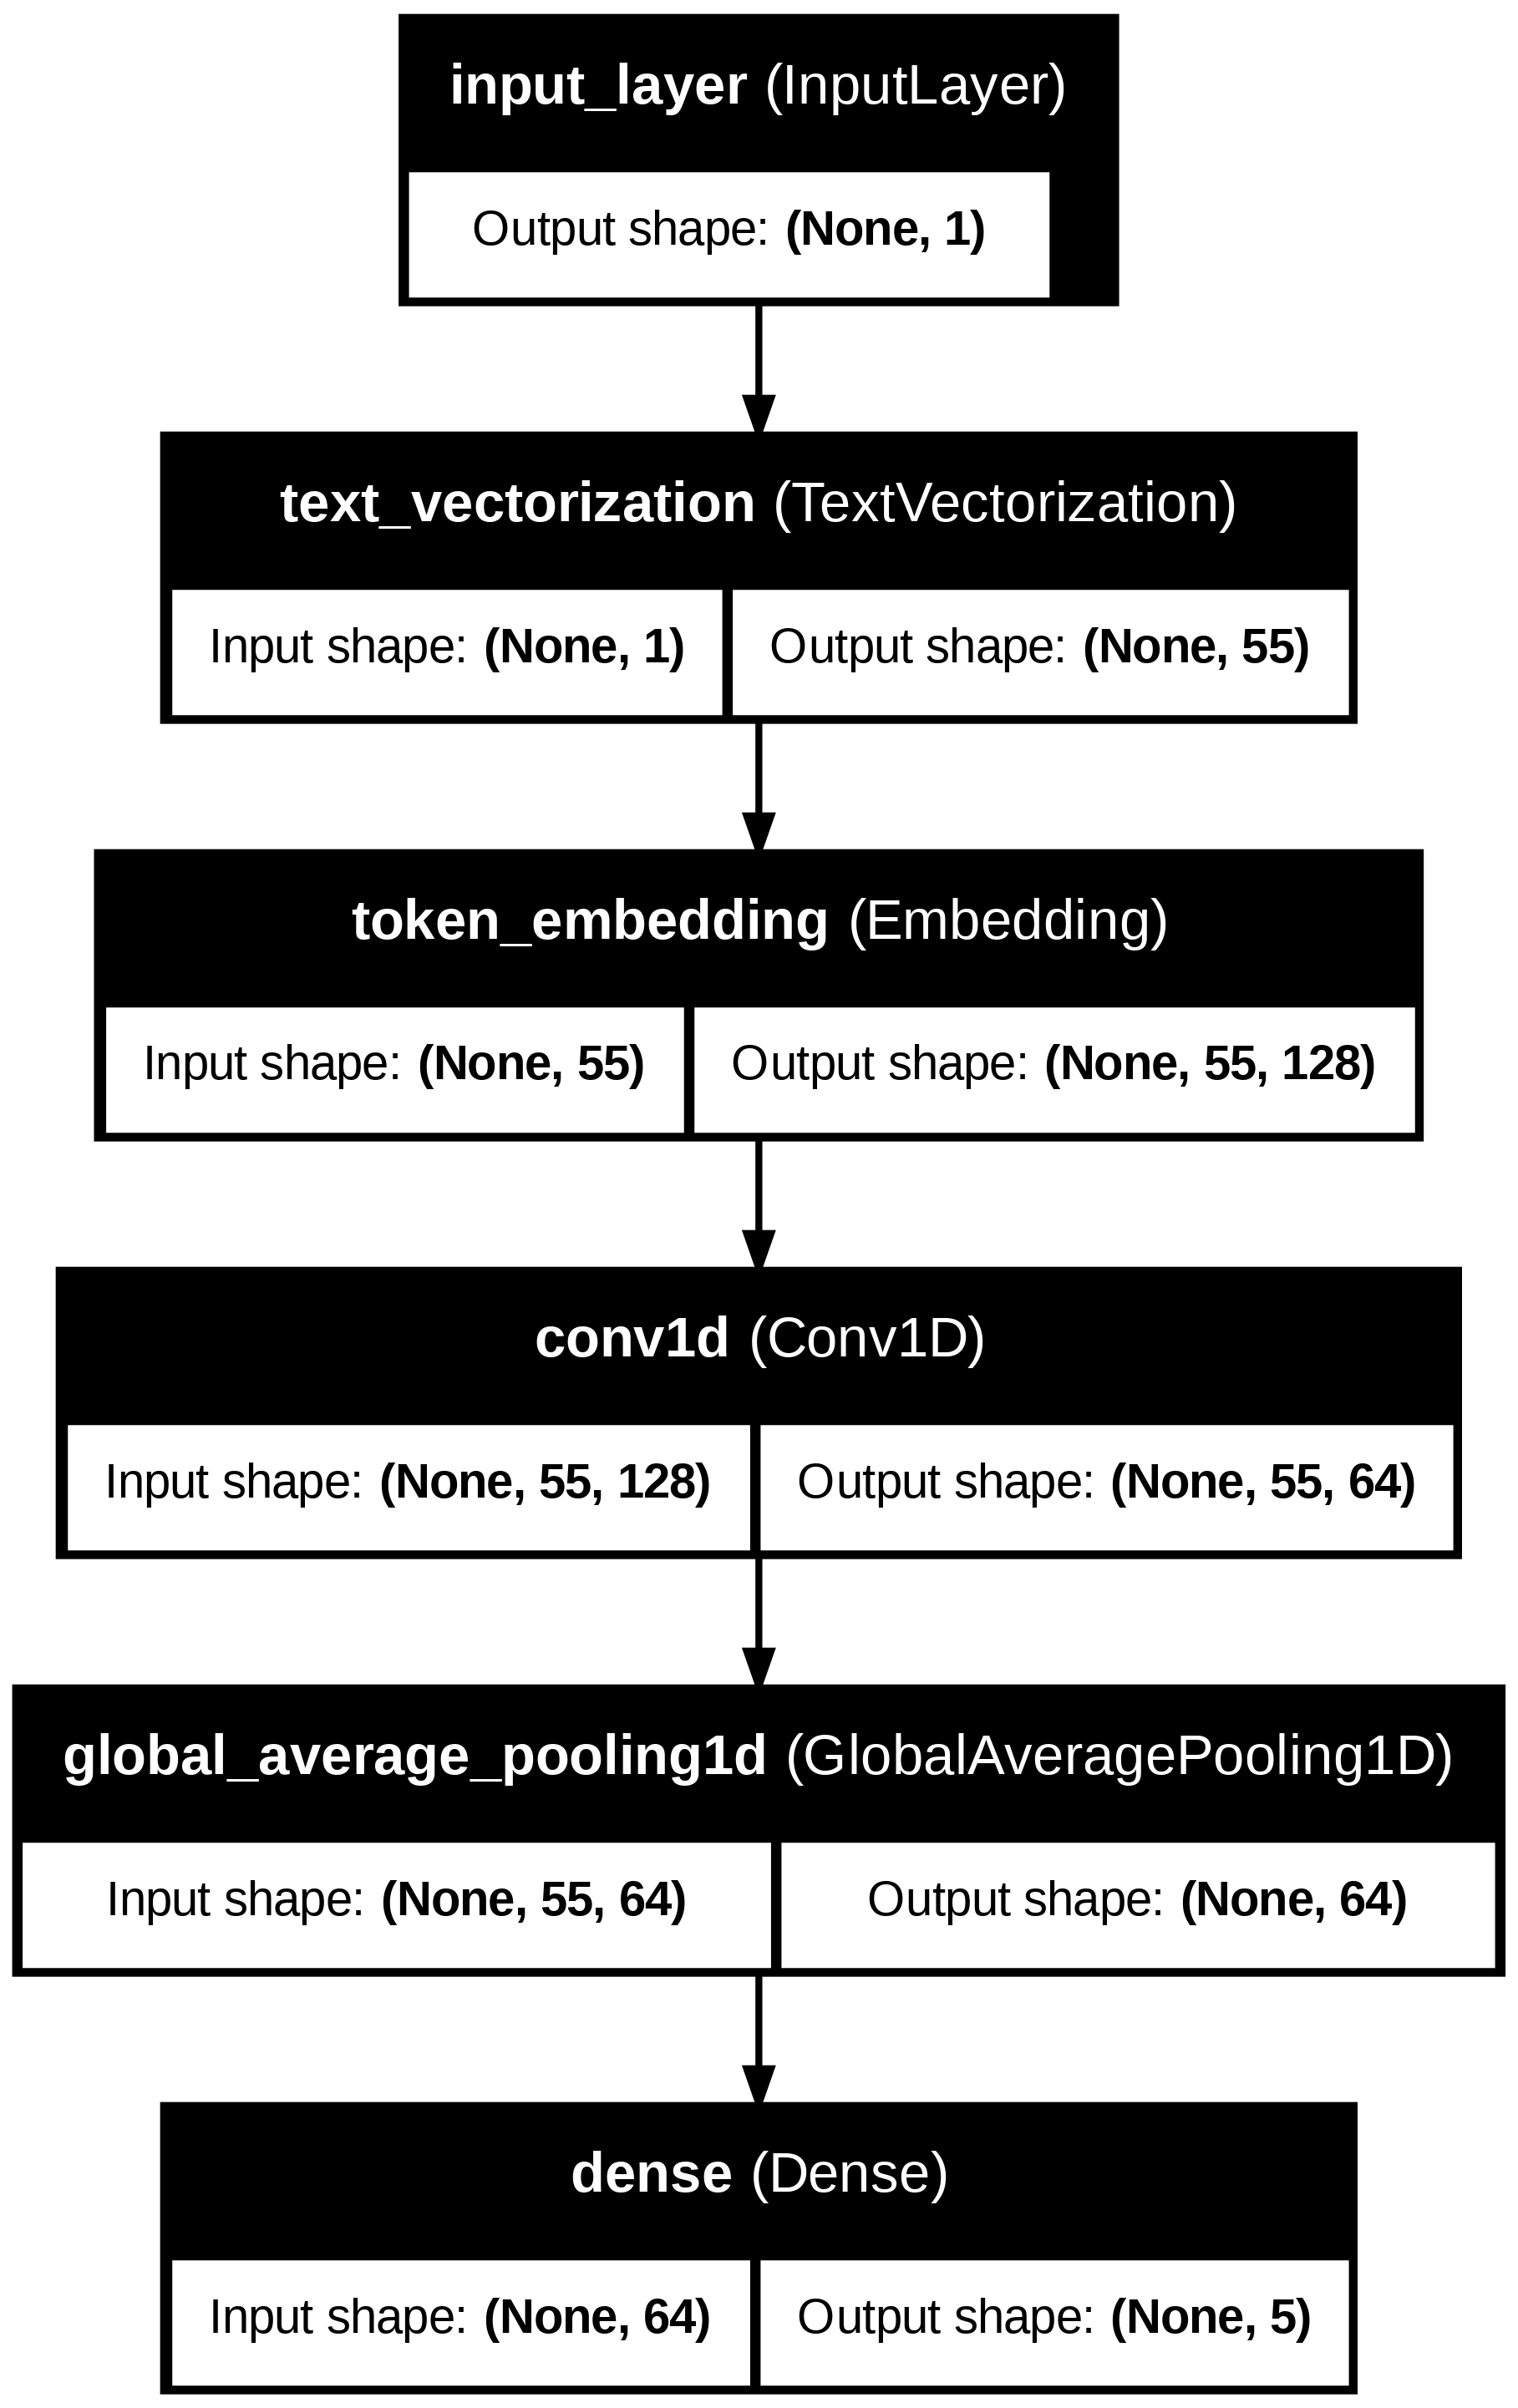

In [44]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_1,
           show_shapes=True,
           expand_nested=True,
           dpi=300,
           show_layer_names=True,
           rankdir='TB')

In [45]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7893 - loss: 0.5961


[0.5973230600357056, 0.7885608077049255]

In [46]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


array([[4.5308906e-01, 1.2858996e-01, 5.1342685e-02, 3.4204891e-01,
        2.4929348e-02],
       [4.0749726e-01, 3.2260755e-01, 1.1178913e-02, 2.4711865e-01,
        1.1597534e-02],
       [1.8912545e-01, 5.1478897e-03, 2.6565345e-03, 8.0302155e-01,
        4.8558319e-05],
       ...,
       [8.1486996e-06, 7.5917493e-04, 7.1973365e-04, 6.0879338e-06,
        9.9850684e-01],
       [4.6984494e-02, 4.6450555e-01, 7.3487192e-02, 4.7944915e-02,
        3.6707783e-01],
       [1.8092470e-01, 6.6625607e-01, 6.1541196e-02, 5.0500892e-02,
        4.0777221e-02]], dtype=float32)

In [47]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.8560836753608,
 'precision': 0.7854351219353617,
 'recall': 0.7885608367536079,
 'f1': 0.7864592052147253}

## Model 2: Feature extraction with pretrained token embeddings

Training our own embeddings took a little while to run, slowing our experiments down.

Since we're moving towards replicating the model architecture in Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it mentions they used a pretrained GloVe embedding as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.

The model structure will look like:

`Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)`

You'll notice the lack of tokenization layer we've used in a previous model. This is because the `Universal Sentence Encoder (USE)` takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, feature extraction transfer learning. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

"https://tfhub.dev/google/universal-sentence-encoder/4"


In [49]:
import tf_keras as tfk
from tf_keras import layers

In [50]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [51]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
australian new zealand clinical trials registry : actrn@ .

Sentence after embedding:
[ 0.01802736 -0.0013548  -0.07265159 -0.03722961 -0.04084098 -0.05131443
  0.0077132   0.02714612 -0.01609484 -0.06627547  0.05120711  0.02827879
  0.03861315 -0.03175025  0.04697493  0.00629506 -0.07701645 -0.06394813
  0.04027992 -0.05434177 -0.07175419  0.04397465 -0.02466321  0.06851806
 -0.06023937  0.0643952  -0.00431163  0.07002225 -0.04662592  0.01186635] (truncated output)...

Length of sentence embedding:
512


In [52]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tfk.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer= "adam",
                metrics=["accuracy"])

In [53]:
# Fit the model
model_2_history = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              validation_data = val_dataset,
                              validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9211 - accuracy: 0.6502 - val_loss: 0.7970 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7699 - accuracy: 0.7004 - val_loss: 0.7575 - val_accuracy: 0.7031
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7546 - accuracy: 0.7115 - val_loss: 0.7437 - val_accuracy: 0.7124


In [54]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[4.5487168e-01, 3.3114702e-01, 2.6508705e-03, 2.0258600e-01,
        8.7444242e-03],
       [3.6889684e-01, 5.0850081e-01, 4.3935282e-03, 1.1533944e-01,
        2.8694409e-03],
       [2.2891593e-01, 1.4548048e-01, 1.7101848e-02, 5.6607056e-01,
        4.2431165e-02],
       ...,
       [1.8709569e-03, 6.7903912e-03, 5.9097759e-02, 9.2654862e-04,
        9.3131435e-01],
       [4.2924266e-03, 5.3591426e-02, 2.2221629e-01, 1.6798601e-03,
        7.1821994e-01],
       [1.8111439e-01, 2.7499095e-01, 4.7890407e-01, 7.2568930e-03,
        5.7733644e-02]], dtype=float32)

In [55]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [56]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.2895538196743,
 'precision': 0.7129751118196502,
 'recall': 0.712895538196743,
 'f1': 0.7097360975610014}

## Model 3: Conv1D with character embeddings

**Creating a character-level tokenizer**


The Neural Networks for Joint Sentence Classification in Medical Paper Abstracts paper mentions their model uses a hybrid of token and character embeddings.

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a token embedding is created on sequences split into tokens.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the TextVectorization class and then passing those vectorized sequences through an Embedding layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

In [57]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'a u s t r a l i a n   n e w   z e a l a n d   c l i n i c a l   t r i a l s   r e g i s t r y   :   a c t r n @   .'

In [58]:
# Split sequence level data splits into character level data splits
train_characters = [split_chars(sentence) for sentence in train_sentences]
val_characters = [split_chars(sentence) for sentence in val_sentences]
test_characters = [split_chars(sentence) for sentence in test_sentences]
train_characters[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [59]:
# Average character length
character_len = [len(sentence) for sentence in train_sentences]
avg_char_len = np.mean(character_len)
avg_char_len

149.3662574983337

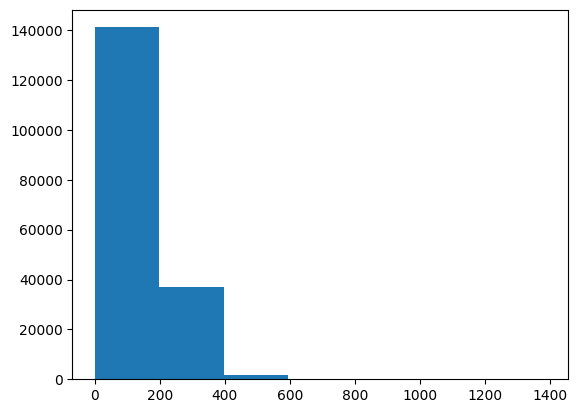

In [60]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(character_len, bins=7);

In [61]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(character_len, 95))
output_seq_char_len

290

We'll set max_tokens (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [62]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [63]:
from tf_keras.layers import TextVectorization

In [64]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [65]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_characters)

In [66]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [67]:
# Test out character vectorizer
random_train_chars = random.choice(train_characters)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
i n   p a r t   @   ,   p a t i e n t s   w i t h   s e v e r e   r e n a l   i m p a i r m e n t   (   c r e a t i n i n e   c l e a r a n c e   <   @   m l / m i n / @   @   m @   c o c k c r o f t - g a u l t   a d j u s t e d   )   r e c e i v e d   a z a c i t i d i n e   @   m g / m @   f o r   @   c o n s e c u t i v e   d a y s   .

Length of chars: 143

Vectorized chars:
[[ 4  6 14  5  8  3 14  5  3  4  2  6  3  9 20  4  3 13  9  2 21  2  8  2
   8  2  6  5 12  4 15 14  5  4  8 15  2  6  3 11  8  2  5  3  4  6  4  6
   2 11 12  2  5  8  5  6 11  2 15 12 15  4  6 15 11  7 11 23 11  8  7 17
   3 18  5 16 12  3  5 10 27 16  9  3  2 10  8  2 11  2  4 21  2 10  5 25
   5 11  4  3  4 10  4  6  2 15 18 15 17  7  8 11  7  6  9  2 11 16  3  4
  21  2 10  5 19  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  

Due to the standardize parameter of TextVectorization being "lower_and_strip_punctuation" and the split parameter being "whitespace" by default, symbols (such as @) and spaces are removed.

### Creating a character-level embedding
Just like our custom token embedding, we can do so using the `tensorflow.keras.layers.Embedding class`.

Our character-level embedding layer requires an input dimension and output dimension.

The input dimension (input_dim) will be equal to the number of different characters in our char_vocab (28). And since we're following the structure of the model in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, the output dimension of the character embedding (output_dim) will be 25.

In [68]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=True,
                              name="char_embed")

In [69]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
i n   p a r t   @   ,   p a t i e n t s   w i t h   s e v e r e   r e n a l   i m p a i r m e n t   (   c r e a t i n i n e   c l e a r a n c e   <   @   m l / m i n / @   @   m @   c o c k c r o f t - g a u l t   a d j u s t e d   )   r e c e i v e d   a z a c i t i d i n e   @   m g / m @   f o r   @   c o n s e c u t i v e   d a y s   .

Embedded chars (after vectorization and embedding):
[[[-0.00675563  0.03811231  0.04489256 ... -0.04005463  0.03965327
    0.01134198]
  [ 0.04134021  0.01174833 -0.02870932 ...  0.00198451  0.01623901
   -0.01464146]
  [ 0.04703503  0.01600519  0.00698517 ... -0.00324755 -0.02834946
   -0.03092133]
  ...
  [-0.03246679  0.01351989 -0.02501618 ...  0.01892732  0.03364016
   -0.03302721]
  [-0.03246679  0.01351989 -0.02501618 ...  0.01892732  0.03364016
   -0.03302721]
  [-0.03246679  0.01351989 -0.02501618 ...  0.01892732  0.03364016
   -0.03302721]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings


In [70]:
# Make Conv1D on chars only
inputs = layers.Input(shape = (1,),dtype = "string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64,kernel_size = 5,padding = "same",activation = "relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes,activation = "softmax")(x)
model_3 = tfk.Model(inputs = inputs,
                    outputs = outputs,
                    name = "model_3_char_embeddings")

# Compile the model
model_3.compile(loss = "categorical_crossentropy",
                optimizer = "adam",
                metrics = ["accuracy"])

In [71]:
model_3.summary()

Model: "model_3_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d (Conv1D)             (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 5)     

In [72]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_characters, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_characters, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [73]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2613 - accuracy: 0.4902 - val_loss: 1.0370 - val_accuracy: 0.5861
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9998 - accuracy: 0.6035 - val_loss: 0.9296 - val_accuracy: 0.6380
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9231 - accuracy: 0.6428 - val_loss: 0.8593 - val_accuracy: 0.6775


In [74]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8764 - accuracy: 0.6656


[0.8763512969017029, 0.6656295657157898]

In [75]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.19434923, 0.40628427, 0.10903619, 0.20694321, 0.08338706],
       [0.14608368, 0.59205425, 0.01682302, 0.17007396, 0.07496507],
       [0.09035429, 0.2806227 , 0.11988914, 0.42905316, 0.08008072],
       ...,
       [0.00960814, 0.03143688, 0.04710491, 0.01248533, 0.89936477],
       [0.01802561, 0.04479559, 0.37599266, 0.02472334, 0.53646284],
       [0.4646217 , 0.28898928, 0.20008011, 0.03451359, 0.01179536]],
      dtype=float32)

In [76]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

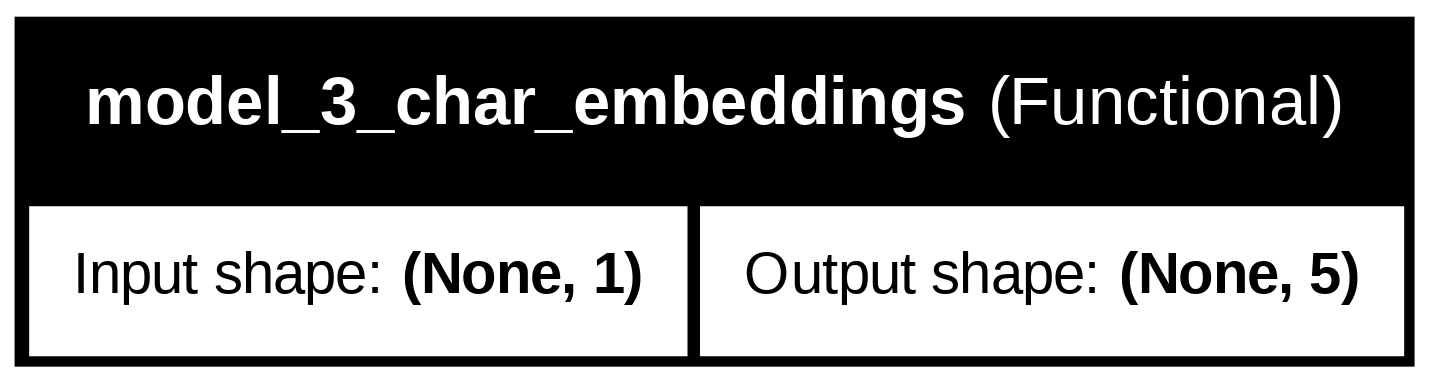

In [77]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_3,
           show_shapes=True,
           expand_nested=True,
           dpi=300,
           show_layer_names=True,
           rankdir='TB')

In [78]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 66.56295511717198,
 'precision': 0.6606823611562869,
 'recall': 0.6656295511717198,
 'f1': 0.658003360610705}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

* Create a token-level model (similar to model_1)
* Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
* Combine (using layers.Concatenate) the outputs of 1 and 2
* Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
* Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output


In [79]:
from tf_keras import layers

In [80]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape = [],dtype = tf.string , name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128,activation = "relu")(token_embeddings)
token_model = tfk.Model(inputs = token_inputs,
                        outputs = token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape = (1,),dtype = tf.string,name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tfk.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output,
                                                                    char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation = "softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tfk.Model(inputs = [token_model.input, char_model.input],
                    outputs = output_layer,
                    name = "model_4")

In [81]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0]']   

In [82]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer= "adam", # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

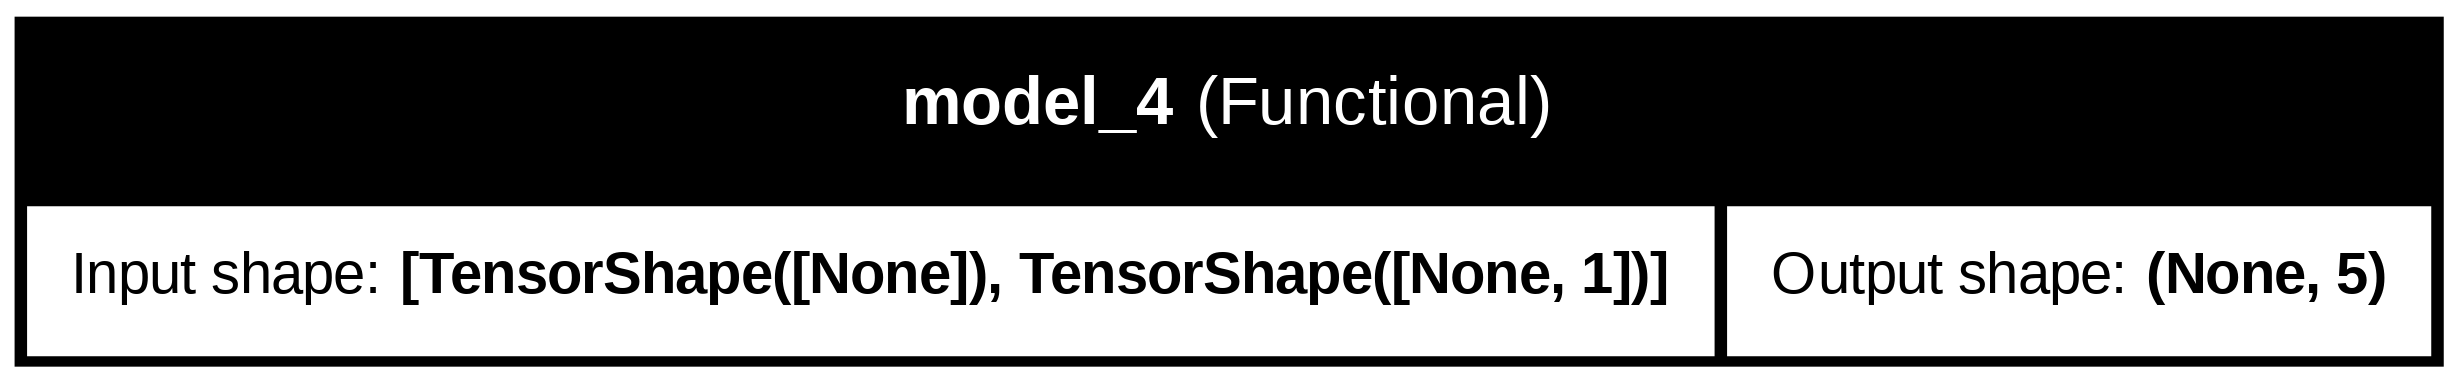

In [83]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4,
           show_shapes=True,
           expand_nested=True,
           dpi=300,
           show_layer_names=True,
           rankdir='TB')

### Combining token and character data into a tf.data dataset

In [84]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_characters)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_characters))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [86]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 41s 53ms/step - loss: 0.9801 - accuracy: 0.6127 - val_loss: 0.7804 - val_accuracy: 0.7005
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.7995 - accuracy: 0.6918 - val_loss: 0.7171 - val_accuracy: 0.7271
Epoch 3/3
562/562 [==============================] - 23s 42ms/step - loss: 0.7795 - accuracy: 0.7028 - val_loss: 0.6954 - val_accuracy: 0.7407


In [87]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.7043 - accuracy: 0.7309


[0.7043374180793762, 0.7309015989303589]

In [88]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 20s 19ms/step


array([[4.58716571e-01, 3.22865546e-01, 4.97591263e-03, 2.07950547e-01,
        5.49145136e-03],
       [4.33940470e-01, 3.75544548e-01, 3.36808013e-03, 1.84793219e-01,
        2.35365238e-03],
       [3.11087668e-01, 1.31075367e-01, 4.21552211e-02, 4.90818471e-01,
        2.48632897e-02],
       ...,
       [1.04908133e-03, 1.46047585e-02, 6.54041916e-02, 3.83647304e-04,
        9.18558300e-01],
       [1.82686802e-02, 7.35966191e-02, 2.01356709e-01, 8.26349016e-03,
        6.98514581e-01],
       [1.82552844e-01, 3.87272954e-01, 3.20414752e-01, 1.91665981e-02,
        9.05928984e-02]], dtype=float32)

In [89]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [90]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.09016284919899,
 'precision': 0.7341536396891063,
 'recall': 0.7309016284919899,
 'f1': 0.7296453993869618}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

 we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,

* Sentence 1 of 10 ...
* Sentence 2 of 10 ...
* Sentence 3 of 10 ...
* Sentence 4 of 10 ...
...

You might've noticed this when we created our `preprocess_text_with_line_numbers()` function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the `"line_number"` and `"total_lines"` columns of our DataFrames.

In [91]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to our model as a positional embedding. In other words, the positional embedding is where the sentence appears in an abstract.

We can use these features because they will be available at test time.

Meaning, if we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and the track the position of each individual line and pass it to our model.

### Create positional embeddings

Since our "line_number" and "total_line" columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with "line_number"=5 is five times greater than a line with "line_number"=1, we'll use one-hot-encoding to encode our "line_number" and "total_lines" features.

To do this, we can use the tf.one_hot utility.

In [92]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

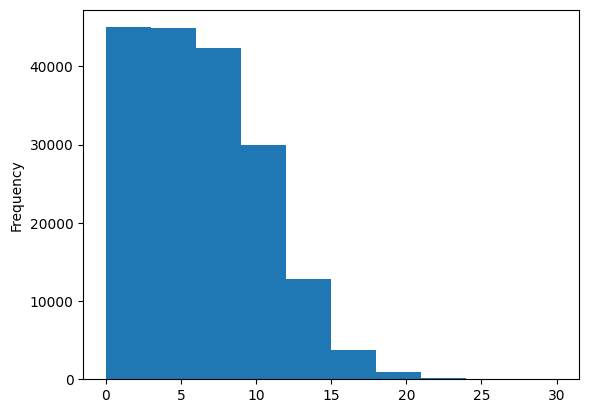

In [93]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Looking at the distribution of the "line_number" column, it looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the depth parameter of tf.one_hot to 15

In [94]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [95]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [96]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


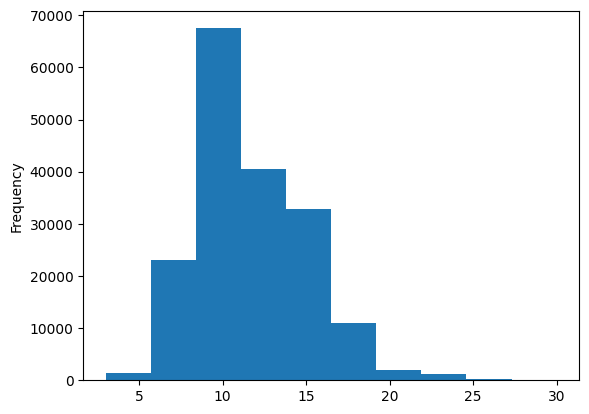

In [97]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [98]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [99]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

More specifically we're going to go through the following steps:

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [100]:
# 1. Token Inputs
token_inputs = layers.Input(shape = [],dtype = "string",name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation = "relu")(token_embeddings)
token_model = tfk.Model(inputs = token_inputs,
                        outputs = token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = (1,),dtype = "string",name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tfk.Model(inputs = char_inputs,
                       outputs = char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape = (15,),dtype = tf.float32,name = "line_number_inputs")
x = layers.Dense(32,activation = "relu")(line_number_inputs)
line_number_model = tfk.Model(inputs = line_number_inputs,
                              outputs = x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape = (20,),dtype = tf.float32 , name = "total_lines_inputs")
y = layers.Dense(32,activation = "relu")(total_lines_inputs)
total_line_model = tfk.Model(inputs = total_lines_inputs,
                             outputs = y)

# 5. Combine token and char embeddings
combined_embeddings = layers.Concatenate(name = "char_token_positional_embedding")([token_model.output,
                                                                                    char_model.output])
z = layers.Dense(256,activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embedding = layers.Concatenate(name = "tribrid_embedding")([line_number_model.output,
                                                                   total_line_model.output,
                                                                    z])
# 7. Create output layer
output_layer = layers.Dense(5,activation = "softmax")(tribrid_embedding)

# 8. Put together the model
model_5 = tfk.Model(inputs = [line_number_model.input,
                              total_line_model.input,
                              token_model.input,
                              char_model.input],
                    outputs = output_layer)

In [101]:
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

In [102]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<tf_keras.src.engine.input_layer.InputLayer object at 0x7af2a357d2d0> True
<tf_keras.src.engine.input_layer.InputLayer object at 0x7af2a357f670> True
<tf_keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7af21e1c1de0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7af2a825e680> False
<tf_keras.src.layers.core.embedding.Embedding object at 0x7af217b8d690> True
<tf_keras.src.layers.core.dense.Dense object at 0x7af2a357f130> True
<tf_keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7af2a35ee350> True
<tf_keras.src.layers.merging.concatenate.Concatenate object at 0x7af2a3415210> True
<tf_keras.src.engine.input_layer.InputLayer object at 0x7af2a35ef790> True
<tf_keras.src.engine.input_layer.InputLayer object at 0x7af2a3414ac0> True
<tf_keras.src.layers.core.dense.Dense object at 0x7af2a17d8550> True
<tf_keras.src.layers.core.dense.Dense object at 0x7af2a357f730> True
<tf_keras.src.layers.core.dense.Dense object at 0x7af2a35a8d60> True
<tf_k

This time, we're going to introduce a new parameter to our loss function called `label_smoothing`.

Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

[0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).

It's predictions will get smoothed to be something like:

[0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization.

In [103]:
# Compile token, char, positional embedding model
model_5.compile(loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer="adam",
                metrics=["accuracy"])

### Create tribrid embedding datasets and fit tribrid model
This time our model requires four feature inputs:

1. Train line numbers one-hot tensor (train_line_numbers_one_hot)
2. Train total lines one-hot tensor (train_total_lines_one_hot)
3. Token-level sequences tensor (train_sentences)
4. Char-level sequences tensor (train_chars)


We can pass these as tuples to our tf.data.Dataset.from_tensor_slices() method to create appropriately shaped and batched PrefetchedDataset's.

In [104]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_characters)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_characters))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [105]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 39s 53ms/step - loss: 1.0972 - accuracy: 0.7228 - val_loss: 0.9837 - val_accuracy: 0.8019
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.9698 - accuracy: 0.8142 - val_loss: 0.9520 - val_accuracy: 0.8225
Epoch 3/3
562/562 [==============================] - 23s 42ms/step - loss: 0.9519 - accuracy: 0.8220 - val_loss: 0.9403 - val_accuracy: 0.8321


In [106]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 21s 19ms/step


array([[0.48208302, 0.11355149, 0.01154795, 0.3703802 , 0.02243731],
       [0.52324146, 0.08646774, 0.04602871, 0.33233306, 0.01192896],
       [0.28520092, 0.11146697, 0.15082398, 0.38429543, 0.06821267],
       ...,
       [0.0303897 , 0.11115809, 0.04514693, 0.02900896, 0.78429633],
       [0.02895462, 0.280314  , 0.08778025, 0.02764911, 0.57530206],
       [0.22282173, 0.58296597, 0.10070889, 0.03900394, 0.05449956]],
      dtype=float32)

In [107]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [108]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.29140738779293,
 'precision': 0.8315245819243219,
 'recall': 0.8329140738779293,
 'f1': 0.83175497001744}

## Compare model results

In [109]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.856084,0.785435,0.788561,0.786459
pretrained_token_embed,71.289554,0.712975,0.712896,0.709736
custom_char_embed_conv1d,66.562955,0.660682,0.665630,0.658003
hybrid_char_token_embed,73.090163,0.734154,0.730902,0.729645
tribrid_pos_char_token_embed,83.291407,0.831525,0.832914,0.831755


In [110]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

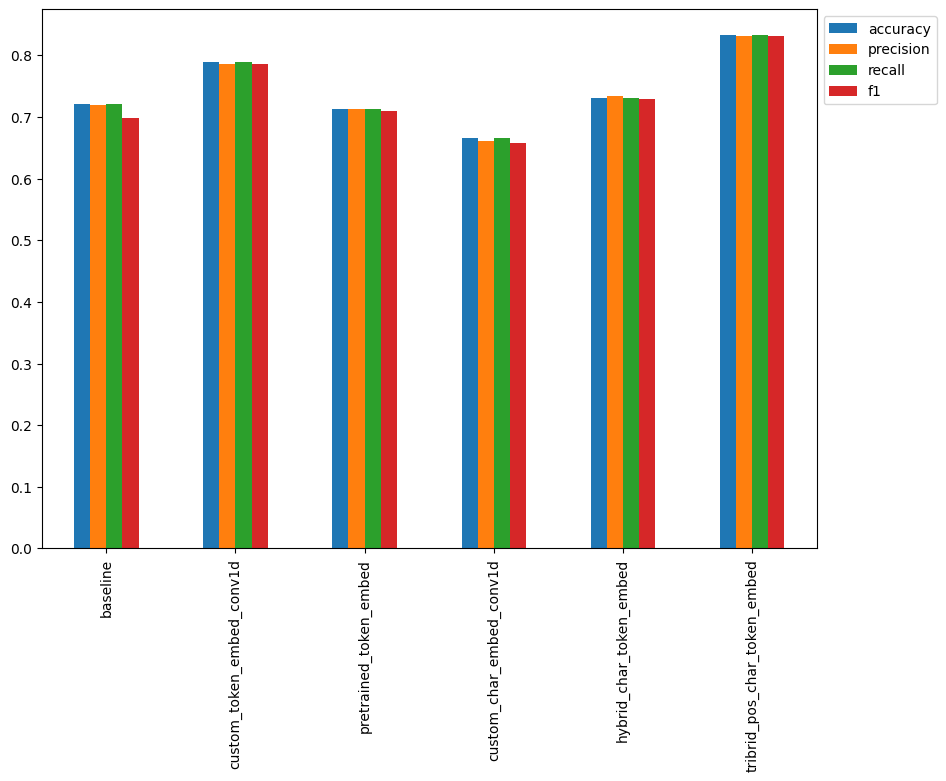

In [111]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

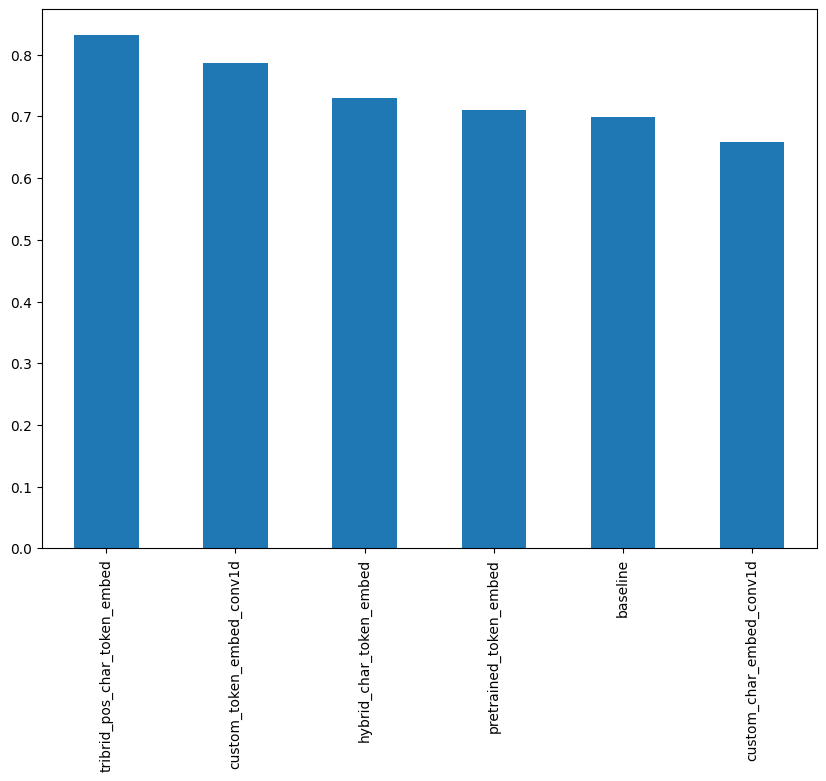

In [112]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

Based on F1-scores, it looks like our tribrid embedding model performs the best by a fair margin.

## Save and load best performing model

In [113]:
# Save best performing model to SavedModel format (default)
model_5.save("MedRead_best_model") # model will be saved to path specified by string

## Evaluate model on test dataset
To make our model's performance more comparable with the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, let's make predictions on the test dataset and evaluate them.

In [114]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_characters))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [115]:
# Make predictions on the test dataset
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 18s 19ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [116]:
# Evaluate loaded model test predictions
model_5_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
model_5_test_results

{'accuracy': 82.54189480670317,
 'precision': 0.8237246360674758,
 'recall': 0.8254189480670316,
 'f1': 0.8241542414264574}

## Make example predictions

we've made some predictions on the test dataset, now's time to really test our model out.

To do so, we're going to get some data from the wild and see how our model performs.

In other words, were going to find an RCT abstract from PubMed, preprocess the text so it works with our model, then pass each sequence in the wild abstract through our model to see what label it predicts.

In [117]:
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

import json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-08-20 17:01:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-08-20 17:01:51 (81.8 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [118]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


First, we'll need to parse it using spaCy to turn it from a big chunk of text into sentences.

In [119]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser
# sentencizer = nlp.create_pipe("sentencizer") # remove this line - no longer needed
nlp.add_pipe("sentencizer") # add sentence splitting pipeline object to sentence parser by name
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [120]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [121]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [122]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [123]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [124]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 3s 3s/step
CPU times: user 2.89 s, sys: 25.1 ms, total: 2.91 s
Wall time: 2.87 s


array([[0.3333644 , 0.09685095, 0.01590321, 0.5276505 , 0.02623099],
       [0.08454228, 0.02234953, 0.7079368 , 0.11677518, 0.06839616],
       [0.11319601, 0.03813732, 0.5819528 , 0.17956063, 0.08715326],
       [0.10939856, 0.09589033, 0.5575186 , 0.08770614, 0.14948636],
       [0.05358454, 0.07173339, 0.48154023, 0.05013559, 0.34300634],
       [0.03287017, 0.07015193, 0.6569034 , 0.04518912, 0.19488537],
       [0.02658846, 0.1169483 , 0.08245094, 0.02640755, 0.7476047 ],
       [0.02280721, 0.08090429, 0.22402526, 0.03759737, 0.63466585]],
      dtype=float32)

In [125]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [126]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [127]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
